<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignment 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

In [2]:
from tensorflow.keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

57344/57026 [==============================] - 0s 1us/step


In [9]:
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(X_train)

X_train = transformer.transform(X_train)
X_test = transformer.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

In [63]:
import os
import datetime
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

model = Sequential([
    Flatten(),
    Dense(16, input_dim=13, activation="relu"),
    Dense(1, activation="relu")
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
13/13 [==============================] - 0s 7ms/step - loss: 577.0759 - mse: 577.0759 - val_loss: 604.1099 - val_mse: 604.1099
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 572.6740 - mse: 572.6740 - val_loss: 599.5097 - val_mse: 599.5097
Epoch 3/100
13/13 [==============================] - 0s 3ms/step - loss: 568.1003 - mse: 568.1003 - val_loss: 594.8647 - val_mse: 594.8647
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 563.4932 - mse: 563.4932 - val_loss: 589.9260 - val_mse: 589.9260
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 558.4160 - mse: 558.4160 - val_loss: 584.5078 - val_mse: 584.5078
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 552.8389 - mse: 552.8389 - val_loss: 578.3608 - val_mse: 578.3608
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 546.6018 - mse: 546.6018 - val_loss: 571.6057 - val_mse: 571.6057
Epoch 8/100
13/13 [========

In [64]:
import pandas as pd

hist = pd.DataFrame(model.history.history) 
hist.head()

,loss,mse,val_loss,val_mse
0,577.075867,577.075867,604.109924,604.109924
1,572.673950,572.673950,599.509705,599.509705
2,568.100342,568.100342,594.864685,594.864685
3,563.493164,563.493164,589.925964,589.925964
4,558.415955,558.415955,584.507751,584.507751


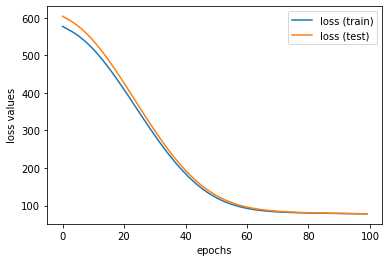

In [65]:
import numpy as np

plt.plot(hist['loss'], label='loss (train)')
plt.plot(hist['val_loss'], label='loss (test)')
plt.xlabel('epochs')
plt.ylabel('loss values')
plt.legend();

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()

model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

mean_squared_error(y_train, y_pred_train), mean_squared_error(y_test, y_pred)

(22.77423909605731, 18.165510493496438)

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- The number of nodes in your output layer should equal the number of classes you want to predict for Fashion-MNIST.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [73]:
from tensorflow.keras.datasets import fashion_mnist

In [75]:
from tensorflow.keras.utils import to_categorical


stop = EarlyStopping(monitor='val_accuracy', min_delta=0.004, patience=6)

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000, 10), (10000, 28, 28), (10000, 10))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
model = Sequential([
    Flatten(),
    Dense(512, input_dim=28, activation="relu"),
    Dense(512, activation="relu"),
    Dense(512, activation="relu"),
    Dense(10, activation="softmax")
])

model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
1875/1875 [==============================] - 23s 12ms/step - loss: 1.5201 - accuracy: 0.7807 - val_loss: 0.5736 - val_accuracy: 0.8012
Epoch 2/50
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4570 - accuracy: 0.8370 - val_loss: 0.5054 - val_accuracy: 0.8241
Epoch 3/50
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4166 - accuracy: 0.8499 - val_loss: 0.4325 - val_accuracy: 0.8420
Epoch 4/50
1875/1875 [==============================] - 23s 12ms/step - loss: 0.3839 - accuracy: 0.8643 - val_loss: 0.4507 - val_accuracy: 0.8457
Epoch 5/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3682 - accuracy: 0.8691 - val_loss: 0.4019 - val_accuracy: 0.8629
Epoch 6/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3540 - accuracy: 0.8746 - val_loss: 0.3860 - val_accuracy: 0.8661
Epoch 7/50
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3411 - accuracy: 0.8778 - val_loss: 0.4091 -

In [82]:
hist = model.history.history

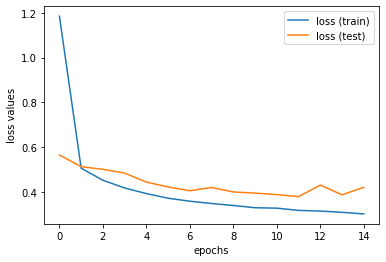

In [84]:
plt.plot(hist['loss'], label='loss (train)')
plt.plot(hist['val_loss'], label='loss (test)')
plt.xlabel('epochs')
plt.ylabel('loss values')
plt.legend();


## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.